# Analysis of Cancer Gene Expression Data

##### Python main module imports for data analysis

In [14]:
# required modules
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

### Data Cleaning

##### Choose the data set:

In [15]:
# read data file
datafile = '~/Documents/THESIS/project/ICOS_DATA/breast_preprocessed.txt'
data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

In [16]:
# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


In [17]:
import thefunc as fu

In [18]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

In [19]:
# check for housekeepnig genes
fu.housekeepgenes('HK_exons.csv',data)

there are 0 house keeping genes.


In [20]:
reload(fu)
X,Y = fu.data_engineer(data,colNames)

In [21]:
# store the gene names/ids
geneNames = X.columns

In [22]:
#Percent of cancer positive
np.mean(Y)

0.65625

## Classification with Penalized Logistic Model

In [23]:
#score_dict = fu.penalty_selector(X,Y,10)
#cv_results = DataFrame.from_dict(data=score_dict, orient='columns', dtype=None).sort(columns = 'accuracy', 
#                                                                                     ascending=False)
#cv_results.to_csv('cv_results.csv')

cv_results = pd.read_csv('cv_results.csv')
print cv_results.iloc[0,2]
print cv_results.iloc[0,3]
cv_results.head()

0.233952406474
0.45


,Unnamed: 0,accuracy,alpha,l1_ratio
0,2448,0.890476,0.233952,0.45
1,2319,0.890476,0.088371,1.00
2,2490,0.883333,0.308982,0.55
3,2394,0.882143,0.154141,0.75
4,2454,0.873810,0.233952,0.75


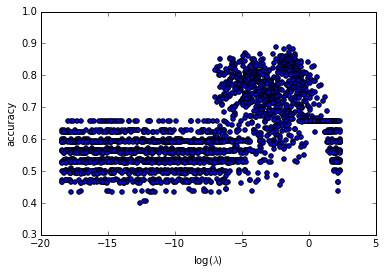

In [24]:
plt.scatter(np.log(cv_results['alpha']),cv_results['accuracy'])
plt.xlabel('log($\lambda$)')
plt.ylabel('accuracy')
plt.show()

In [25]:
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
penalty = cv_results.iloc[0,2]
mix = cv_results.iloc[0,3]
#penalty = 0.175
#mix = 0.5
log_model = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = penalty, l1_ratio = mix, 
                          fit_intercept = True)

### Significant Gene Selection Cross-Validation

In [26]:
selectResult = fu.geneSelector(X,Y,log_model,500)
gene_coeff = selectResult['coeff']
gene_select_count = selectResult['frequency']

In [27]:
threshold = 0.0
results, feature_select_summary = fu.param_calculator(geneNames,gene_coeff,gene_select_count,threshold)

In [28]:
results[['Feature', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()

,Feature,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,1.80153,0.4261463,1.181552e-05
5644,GI_21614543-S,500,-1.181595,0.3643292,0.0005909612
17275,GI_38455428-S,500,1.091122,0.4106187,0.003938887
26033,GI_9951924-S,499,0.8345754,0.3592662,0.01008957
10064,GI_29738585-S,499,0.7518743,0.3036718,0.006644227


In [29]:
GI_4503602_S = X['GI_4503602-S']
GI_38455428_S = X['GI_38455428-S']
GI_21614543_S = X['GI_21614543-S']
GI_29738585_S = X['GI_29738585-S']

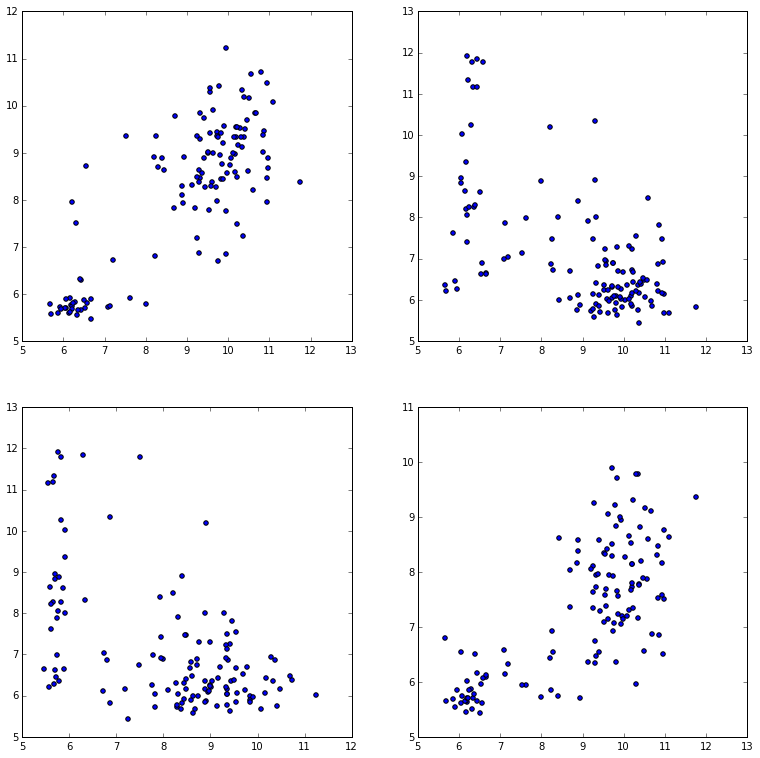

In [30]:
plt.figure(figsize=(13,13))
plt.subplot(2,2,1)
plt.scatter(GI_4503602_S,GI_38455428_S)
plt.subplot(2,2,2)
plt.scatter(GI_4503602_S,GI_21614543_S)
plt.subplot(2,2,3)
plt.scatter(GI_38455428_S,GI_21614543_S)
plt.subplot(2,2,4)
plt.scatter(GI_4503602_S,GI_29738585_S)
plt.show()

In [31]:
print len(results['Feature'])
results[['Feature', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head(4)

1003


,Feature,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,1.80153,0.4261463,1.181552e-05
5644,GI_21614543-S,500,-1.181595,0.3643292,0.0005909612
17275,GI_38455428-S,500,1.091122,0.4106187,0.003938887
26033,GI_9951924-S,499,0.8345754,0.3592662,0.01008957


In [32]:
#Need to create X_sel

X_sel = X[results.index]

X_sel.shape

(128, 1003)

In [33]:
# this gives the model's score
log_model.fit(X_sel,Y)
print log_model.score(X_sel,Y)

0.8359375


In [34]:
class_prob = log_model.predict_proba(X_sel)

In [35]:
dfprob = DataFrame(class_prob)
print dfprob.mean()

0    0.396494
1    0.603506
dtype: float64


### Mean Accuracy

In [36]:
reload(fu)
model2 = LogisticRegression(dual = False, fit_intercept = True)
mean_acc, std_acc, mean_roc, std_roc = fu.accuracy_calculator(model2,X_sel,Y,1000)
print mean_acc
print mean_roc

0.8693125
0.841368530295


In [37]:
np.corrcoef(X_sel)

array([[ 1.        ,  0.78996895,  0.76025896, ...,  0.65518503,
         0.55757269,  0.67925477],
       [ 0.78996895,  1.        ,  0.83693747, ...,  0.60996732,
         0.60628676,  0.7804882 ],
       [ 0.76025896,  0.83693747,  1.        , ...,  0.61254999,
         0.62127547,  0.83129553],
       ..., 
       [ 0.65518503,  0.60996732,  0.61254999, ...,  1.        ,
         0.71543713,  0.64457717],
       [ 0.55757269,  0.60628676,  0.62127547, ...,  0.71543713,
         1.        ,  0.57810465],
       [ 0.67925477,  0.7804882 ,  0.83129553, ...,  0.64457717,
         0.57810465,  1.        ]])

## Classification with Random Forest

#### Use MDI


In [38]:
# model definition
# random forest
rf_model = RandomForestClassifier(n_estimators = 500)

In [39]:
reload(fu)
selectResults2 = fu.geneSelector2(X,Y,geneNames,rf_model,500)

In [40]:
gene_impurity = selectResults2['impurity']
gene_select_count = selectResults2['frequency']

In [41]:
rf_model.feature_importances_

array([ 0.        ,  0.        ,  0.00037754, ...,  0.        ,
        0.        ,  0.        ])

In [42]:
gene_imp_score = gene_impurity.mean(axis = 1);
gene_imp_score = gene_imp_score.abs()

In [43]:
### this creates a pandas Series with the sum of how many times a gene was chosen
gene_select_summary = gene_select_count.sum(axis = 1)

gene_select_summary.head()

0    78
1    47
2    68
3    11
4    26
dtype: int64

In [44]:
# this data frame has the values for all genes
DataFrame([geneNames, gene_select_summary, gene_imp_score], index = 
          ['Gene', 'Frequency', 'MDI']).T.sort(['MDI', 'Frequency'], 
                                                            ascending = False).head(10)

,Gene,Frequency,MDI
22089,GI_4503602-S,496,0.004330461
1800,GI_14249703-S,494,0.003445402
2518,GI_16507967-S,495,0.003269892
22149,GI_4503928-S,492,0.002886306
16849,GI_38146007-A,493,0.002859156
26033,GI_9951924-S,491,0.002707952
6483,GI_22748948-S,492,0.002667235
6671,GI_22779933-S,491,0.002629131
10064,GI_29738585-S,490,0.00255822
13905,GI_34452698-S,483,0.002497511


In [45]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[gene_imp_score >= 0.000125].index

In [67]:
print len(selected_genes_index)
DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index]], index = ['Gene', 'Frequency', 
                                                           'MDI']).T.sort(['MDI', 'Frequency'],
                                                                                  ascending = False).head(10)

1057


,Gene,Frequency,MDI
794,GI_4503602-S,496,0.004330461
74,GI_14249703-S,494,0.003445402
106,GI_16507967-S,495,0.003269892
799,GI_4503928-S,492,0.002886306
620,GI_38146007-A,493,0.002859156
1001,GI_9951924-S,491,0.002707952
284,GI_22748948-S,492,0.002667235
290,GI_22779933-S,491,0.002629131
412,GI_29738585-S,490,0.00255822
565,GI_34452698-S,483,0.002497511


In [47]:
#Need to create X_sel

X_sel = X[selected_genes_index]

X_sel.shape

(128, 1057)

In [48]:
# Make a new log_model
#log_model2 = LogisticRegression()
ensemble_model2 = RandomForestClassifier(n_estimators = 500)

xvalacc = []
xvalROC = []
M = 100

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    ensemble_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = ensemble_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

In [49]:
np.mean(xvalacc)

0.87437500000000001

In [50]:
np.mean(xvalROC)

0.84460381703163212

# Spectral Clustering

In [51]:
from sklearn.cluster import SpectralClustering
import matplotlib.cm as cm

In [52]:
spclus = SpectralClustering(affinity='nearest_neighbors', n_neighbors=20, n_clusters=6, assign_labels='discretize')
spclus_pred = spclus.fit_predict(X_sel.T)
print spclus_pred[:100]

[3 1 5 4 4 2 2 2 0 4 5 5 3 2 0 5 2 0 1 3 2 2 1 1 4 4 5 5 4 1 2 2 4 4 3 1 2
 5 3 4 1 1 2 3 3 1 1 2 1 4 1 2 4 2 4 4 5 2 5 3 1 5 2 1 4 0 5 5 0 3 2 5 5 2
 4 1 4 2 2 5 4 5 0 3 5 3 0 5 2 2 5 3 4 2 4 2 4 4 5 2]


In [53]:
spclus_pred.shape

(1057,)

#### Need to create adjecency matrix.

In [54]:
from sklearn.neighbors import kneighbors_graph
W = kneighbors_graph(X_sel.T, 20, mode = 'distance', include_self=True)
'''print W
print type(W)
print W.shape
print(W.todense)''';

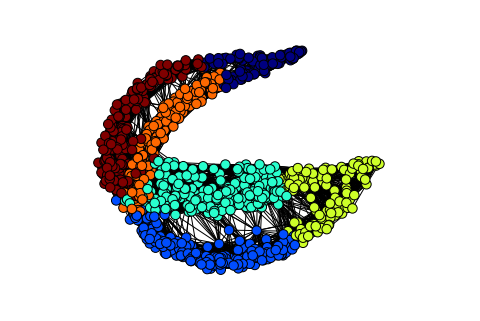

In [55]:
import networkx as nx
G = nx.from_scipy_sparse_matrix(W)
node_colors= spclus_pred
nx.draw(G, node_size = 90, node_color = spclus_pred, cmap = 'jet') # cmap=cm.RdYlGn)

In [56]:
G.size()

17183

### Power Law Analysis

In [57]:
deg = G.degree().values()
print len(deg)
deg[:3]

1057


[32, 22, 57]

1057


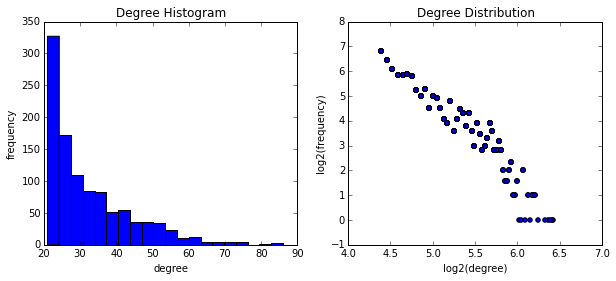

In [58]:
freq = [deg.count(x) for x in deg]

print len(deg)

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.hist(deg, bins = 20)
plt.title('Degree Histogram')
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.scatter(np.log2(deg),np.log2(freq))
plt.title('Degree Distribution')
plt.xlabel('log2(degree)')
plt.ylabel('log2(frequency)')
plt.show()

In [59]:
histo = nx.degree_histogram(G)
count = 0
d = 29
for d in range(1,d):
    count += histo.count(d)
print count


47


##### Most Connected

In [60]:
print max(deg)

86


In [61]:
# find the position of highest degree node in degree value list
degarray = np.asarray(deg)
np.where(degarray == 91)

(array([], dtype=int64),)

In [62]:
deg[213]

44

###### Tail probabilities:
$$\bar{F}\left(d\right) = 1-F\left(d\right)\sim d^{-\left(\alpha - 1\right)}$$
###### Estimate $\alpha$

###### The MLE of $\alpha$ is:
$$\hat{\alpha}_k = 1 + \hat{\gamma}_k^{-1}$$

###### With:
$$\hat{\gamma}_k = \frac{1}{k} \sum_{i=0}^{k-1} \log{\frac{d_\left(N_v-i\right)}{d_\left(N_v-k\right)}}$$

In [63]:
def alphaK(deg,k):
    deg.sort()
    degorder = np.asarray(deg)
    gammaK = sum(np.log(degorder[-k:]/float(degorder[len(deg) - k])))/k
    alpha = 1 + gammaK**-1
    return alpha

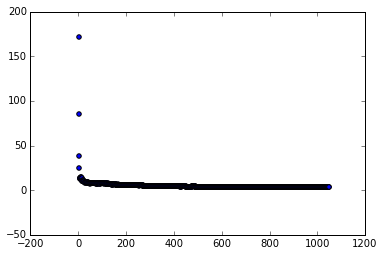

In [64]:
kvec = range(2,1049)
alpha = [alphaK(deg,i) for i in kvec]

plt.scatter(kvec,alpha)
plt.show()

In [65]:
alphaK(deg,2)

171.99805066448448

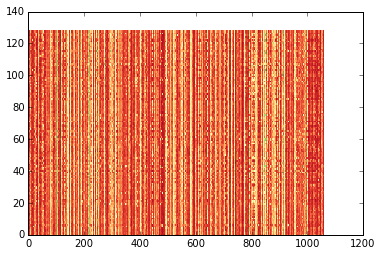

In [66]:
plt.pcolor(X_sel, cmap=cm.RdYlGn)
plt.show()

## Constructing a Markov Random Field